Group name: VDC group | Members: Chu-Ching Ho, Di Wu, Van Ly Nguyen

# Preparation

We first load the data into memory and split data into training data and validation data as following:

In [34]:
import numpy as np
np.random.seed(0)
import mltools as ml
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
CSV_FILE_PATH = 'data/diabetic_data.csv'
data = pd.read_csv(CSV_FILE_PATH)

print(data.shape)
print(data.info())

(101766, 50)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient    

Because not all features are useful, we could do a feature selection before training our model.
Our features include much personal information about patients such as age, weight, race and many other medical treatment results. 

We can see there are 101766 data and 49 features in the original data. And Y is the class label of each specific data point. 
For some very obvious features (like "encounter_id", "patient_nbr"), we can say they are just idenitities and are not related to our prediction (readmitted info) so we just ignore them. For feature examide and citoglipton, they only have 1 value and cannot be used in prediction.
Further, among our data there are many missing value as mentioned in the essay. And we can just drop those features with missing rate higher than certain value (eg. 40%).

In [35]:
for col in data.columns:
    if data[col].dtype == object:
        count = data[col][data[col] == '?'].count()
        if count != 0:
            print(col, count)
print('gender', data['gender'][data['gender'] == 'Unknown/Invalid'].count())

('race', 2273)
('weight', 98569)
('payer_code', 40256)
('medical_specialty', 49949)
('diag_1', 21)
('diag_2', 358)
('diag_3', 1423)
('gender', 3)


In [36]:
# identities
data = data.drop('encounter_id', axis=1)
data = data.drop('patient_nbr', axis=1)
# only contains one value
data = data.drop('examide', axis=1)
data = data.drop('citoglipton', axis=1)
# missing rate is high
data = data.drop('weight', axis=1)
data = data.drop('payer_code', axis=1)
data = data.drop('medical_specialty', axis=1)

We should also remove some records:
for those records with diag1, diag2 and diag3 all missing, we should get rid of them. And we also remove records with gender = 'Unknown/Invalid'.

In [37]:
diag_Idx = set(data[(data['diag_1'] == '?') & (data['diag_2'] == '?') & (data['diag_3'] == '?')].index)
gender_Idx = set(data['gender'][data['gender'] == 'Unknown/Invalid'].index)
data = data.drop(data.index[list(diag_Idx.union(gender_Idx))])
print(data.shape)

(101762, 43)


For the remaining data missing, we should replace them with np.nan.

In [38]:
data = data.replace('?',np.nan)

We are predicting whether a patient will occur readmission after treatment. And for patients with >30 days' readmitted, we replace them with 0. For readmitted in more than 30 days has very little correlated factor with first admitted.
The distribution of our classes is like the following:

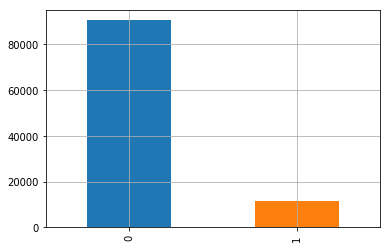

<Figure size 360x216 with 0 Axes>

readmitted
0    90405
1    11357
dtype: int64
                                  0          1                2          3  \
race                      Caucasian  Caucasian  AfricanAmerican  Caucasian   
gender                       Female     Female           Female       Male   
age                          [0-10)    [10-20)          [20-30)    [30-40)   
admission_type_id                 6          1                1          1   
discharge_disposition_id         25          1                1          1   
admission_source_id               1          7                7          7   
time_in_hospital                  1          3                2          2   
num_lab_procedures               41         59               11         44   
num_procedures                    0          0                5          1   
num_medications                   1         18               13         16   
number_outpatient                 0          0                2          0   
number_emergency  

In [39]:
data['readmitted'] = data['readmitted'].replace('>30', 0)
data['readmitted'] = data['readmitted'].replace('<30', 1)
data['readmitted'] = data['readmitted'].replace('NO', 0)
data['readmitted'].value_counts().plot(kind='bar', grid=True)
plt.figure(figsize=(5,3))
plt.show()
print(data.groupby('readmitted').size())
print(data.head().T)

From bar chart above among 101,767 data, we could see that nearly 90,405 data point with "readmitted", 11,357 labeled "no readmitted". That means patients without readmitted are more frequent and patients with readmitted much smaller  which is consistent with common sense.
After knowing about our classes, we want to know more about our features which is vital to train our model and make corresponding prediction in the following. 

# Feature selection

For some numeric features, we could plot the density distribution of each feature and get rid of unuseful features in the following (classification density is same over different values).

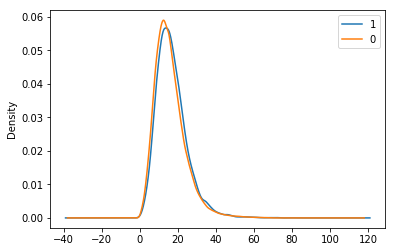

In [40]:
# for feature num_medications
data['num_medications'][data['readmitted'] == 1].plot(kind='kde')
data['num_medications'][data['readmitted'] == 0].plot(kind='kde')
plt.legend(('1', '0'),loc='best')
plt.show()

For this 'num_medications' feature, we find the density of 0, 1 and 2 almost overlapped. It means it nearly makes no contribution to class decision. We should get rid of it.

In [41]:
data = data.drop('num_medications', axis=1)

After that, we should do some encoding for some nominal features as following:

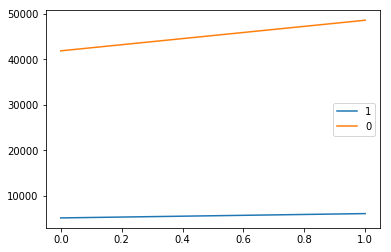

In [42]:
from collections import OrderedDict as odict

# For feature gender, we should code 'male' and 'female' using 0 and 1
data['gender'] = data['gender'].replace('Male',0)
data['gender'] = data['gender'].replace('Female',1)

feat2 = pd.concat([data.iloc[:,1], data['readmitted']], axis=1)
feat2_lt30 = feat2[feat2['readmitted'] == 1]
feat2_no = feat2[feat2['readmitted'] == 0]

feat2_1 = dict(feat2_lt30['gender'].value_counts())
feat2_1 = odict(sorted(feat2_1.items()))

feat2_2 = dict(feat2_no['gender'].value_counts())
feat2_2 = odict(sorted(feat2_2.items()))

plt.plot(list(feat2_1.keys()), list(feat2_1.values()), label="class_1")
plt.plot(list(feat2_2.keys()), list(feat2_2.values()), label="class_2")
plt.legend(('1', '0'),loc='best')
plt.show()

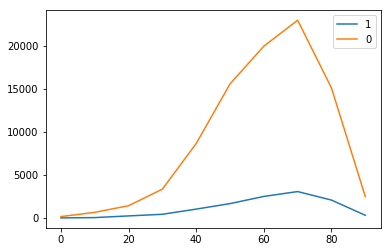

In [43]:
# for feature age

# for age feature with '[i - i+10)' representation,
# we should replace them with the begining number to turn this feature into numeric
data['age'] = data['age'].replace('[0-10)',0)
data['age'] = data['age'].replace('[10-20)',10)
data['age'] = data['age'].replace('[20-30)',20)
data['age'] = data['age'].replace('[30-40)',30)
data['age'] = data['age'].replace('[40-50)',40)
data['age'] = data['age'].replace('[50-60)',50)
data['age'] = data['age'].replace('[60-70)',60)
data['age'] = data['age'].replace('[70-80)',70)
data['age'] = data['age'].replace('[80-90)',80)
data['age'] = data['age'].replace('[90-100)',90)

feat4 = pd.concat([data.iloc[:,2], data['readmitted']], axis=1)
feat4_lt30 = feat4[feat4['readmitted'] == 1]
feat4_no = feat4[feat4['readmitted'] == 0]

feat4_1 = dict(feat4_lt30['age'].value_counts())
feat4_1 = odict(sorted(feat4_1.items()))

feat4_2 = dict(feat4_no['age'].value_counts())
feat4_2 = odict(sorted(feat4_2.items()))

plt.plot(list(feat4_1.keys()), list(feat4_1.values()), label="class_1")
plt.plot(list(feat4_2.keys()), list(feat4_2.values()), label="class_2")
plt.legend(('1', '0'),loc='best')
plt.show()

In [44]:
# For other discrete features, we should also replace them with numeric value
data['change'] = data['change'].replace('Ch', 1)
data['change'] = data['change'].replace('No', 0)

data['diabetesMed'] = data['diabetesMed'].replace('Yes', 1)
data['diabetesMed'] = data['diabetesMed'].replace('No', 0)

data['max_glu_serum'] = data['max_glu_serum'].replace('>300', 3)
data['max_glu_serum'] = data['max_glu_serum'].replace('>200', 2)
data['max_glu_serum'] = data['max_glu_serum'].replace('Normal', 1)
data['max_glu_serum'] = data['max_glu_serum'].replace('None', 0)

data['A1Cresult'] = data['A1Cresult'].replace('>8', 3)
data['A1Cresult'] = data['A1Cresult'].replace('>7', 2)
data['A1Cresult'] = data['A1Cresult'].replace('Normal', 1)
data['A1Cresult'] = data['A1Cresult'].replace('None', 0)

For feature race, it is a discrete Nominal feature with values: Caucasian, Asian, African American, Hispanic, and other. We would like to transform it into a numeric feature. Here we use one-hot encoding. In ont-hot encoding, we create 5 additional columns for every values in 'race' and each has value 1 if record has that value or 0 otherwise.

In [45]:
def create_dummies(data,column_name):
    dummies = pd.get_dummies(data[column_name],prefix=column_name, drop_first = True)
    print(dummies.head().T)
    data = pd.concat([data,dummies],axis=1)
    data = data.drop(column_name, axis=1)
    return data

data = create_dummies(data, 'race')
# data = create_dummies(data, 'max_glu_serum')
# data = create_dummies(data, 'A1Cresult')

                0  1  2  3  4
race_Asian      0  0  0  0  0
race_Caucasian  1  1  0  1  1
race_Hispanic   0  0  0  0  0
race_Other      0  0  0  0  0


There are 24 kinds of drug related features, we didn't know the details of each drugs and their efficacy. They indicate whether the dosage of each drug has been changed during treatment. “up” indicates increasing during the encounter, “down” indicates decreasing, “steady” indicates no change, and “no” indicates no prescribed (which also means no change).
In order to simplify our model, we only use the number of dosage change during encounter instead of using them all which means we don't distinguish changes between drugs and will combine the changes together among all 24 changes.

In [46]:
drugs = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
         'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
         'rosiglitazone', 'acarbose', 'miglitol', 'insulin',
         'glyburide-metformin', 'tolazamide',
         'metformin-pioglitazone','metformin-rosiglitazone',
         'glimepiride-pioglitazone', 'glipizide-metformin',
         'troglitazone', 'tolbutamide', 'acetohexamide']
data['drug_change_num'] = 0
for drug in drugs:
    data['drug_change_num'] += data[drug].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)
    data = data.drop(drug, axis=1)

print(data['drug_change_num'].value_counts())

0    74059
1    26272
2     1318
3      108
4        5
Name: drug_change_num, dtype: int64


After all data preprocessing is done, we should shuffle our data and split them into training data (80%) and testing data (20%).

In [47]:
data = data.sample(n = len(data)).reset_index(drop = True)
print(data.shape)

(101762, 25)


In [48]:
Y = data.readmitted
X = data.drop('readmitted', axis=1)
print(X.shape)
print(Y.shape)
X = X.apply(pd.to_numeric, errors='coerce')
Y = Y.apply(pd.to_numeric, errors='coerce')
X.fillna(0, inplace=True)
Y.fillna(0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.2)

(101762, 24)
(101762,)


# Model build

## Logistic regression

We first choose logistic regression model. We use our training data to train the model and make prediction for both training data and testing data and finally calculate ROC AUC and Accuracy for our prediction.

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score

lr = LogisticRegression()
lr.fit(X_train, y_train)

logregression_y_train_predict = lr.predict_proba(X_train)[:,1]
logregression_y_test_predict = lr.predict_proba(X_test)[:,1]

threshold = 0.5

print('Training result:')
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, logregression_y_train_predict)
print('AUC=',auc(fpr_train, tpr_train))
print('Accuracy=',accuracy_score(y_train, (logregression_y_train_predict > threshold)))

print('Testing result:')
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, logregression_y_test_predict)
print('AUC=',auc(fpr_test, tpr_test))
print('Accuracy=',accuracy_score(y_test, (logregression_y_test_predict > threshold)))

Training result:
('AUC=', 0.6416803958636719)
('Accuracy=', 0.8882433146212335)
Testing result:
('AUC=', 0.6381560490621228)
('Accuracy=', 0.8883211320198496)


It can get 0.638 score in test data

## Random forest

### max_depth and min_sample_split

Text(0.5,1.05,'test AUC score under different max_depth and min_split')

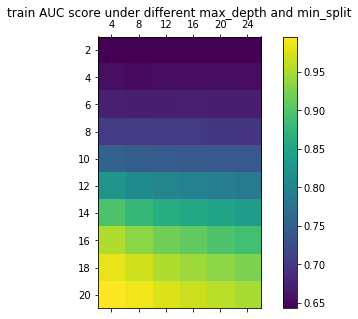

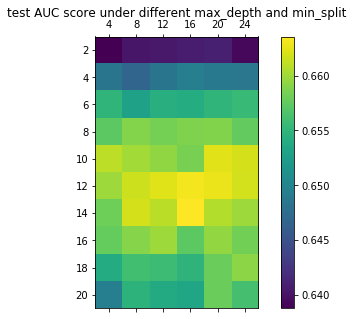

In [51]:
from sklearn.ensemble import RandomForestClassifier

max_depth_arr = [2,4,6,8,10,12,14,16,18,20]
min_sample_split=[4,8,12,16,20,24]
tr_auc = np.zeros((len(max_depth_arr),len(min_sample_split)))
te_auc = np.zeros((len(max_depth_arr),len(min_sample_split)))
for i,d in enumerate(max_depth_arr):
    for j,s in enumerate(min_sample_split):
        clf = RandomForestClassifier(n_estimators=100, n_jobs=4,
                                     max_depth=d, min_samples_split=s)
        clf.fit(X_train, y_train)
        randomforest_y_train_predict = clf.predict_proba(X_train)[:,1]
        randomforest_y_test_predict = clf.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_train, randomforest_y_train_predict)
        tr_auc[i][j]=auc(fpr, tpr)
        fpr, tpr, thresholds = roc_curve(y_test, randomforest_y_test_predict)
        te_auc[i][j]=auc(fpr, tpr)
f, ax = plt.subplots(1, 1, figsize=(8, 5))
cax = ax.matshow(tr_auc, interpolation='nearest')
f.colorbar(cax)
ax.set_yticklabels(list(max_depth_arr))
ax.set_xticklabels(list(min_sample_split))
ax.set_yticks(np.arange(len(max_depth_arr)))
ax.set_xticks(np.arange(len(min_sample_split)))
ax.set_title('train AUC score under different max_depth and min_split')

f, ax = plt.subplots(1, 1, figsize=(8, 5))
cax = ax.matshow(te_auc, interpolation='nearest')
f.colorbar(cax)
ax.set_yticklabels(list(max_depth_arr))
ax.set_xticklabels(list(min_sample_split))
ax.set_yticks(np.arange(len(max_depth_arr)))
ax.set_xticks(np.arange(len(min_sample_split)))
ax.set_title('test AUC score under different max_depth and min_split')

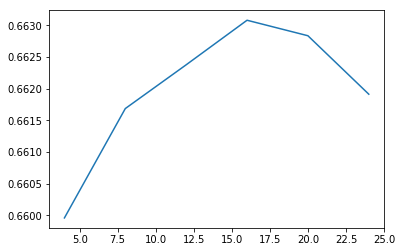

In [59]:
plt.plot(min_sample_split, te_auc[5,:])
plt.show()

From plot above, we could know min sample split produce the best result when it equals to 16 and max depth produce best result when it equals to 12

### n_estimators

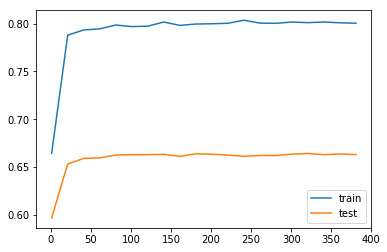

In [61]:
train_results=np.zeros(20)
test_results=np.zeros(20)
x=range(0,20)
for i in range(0,20):
    clf = RandomForestClassifier(n_estimators=20*i+1, n_jobs=4, max_depth=12,
                                      min_samples_split=16, min_samples_leaf=1)
    clf.fit(X_train, y_train)
    randomforest_y_train_predict1=clf.predict_proba(X_train)[:,1]
    randomforest_y_test_predict1=clf.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_train, randomforest_y_train_predict1)
    train_results[i]=auc(fpr, tpr)
    fpr, tpr, thresholds = roc_curve(y_test, randomforest_y_test_predict1)
    test_results[i]=auc(fpr, tpr)
    x[i] = 20*i+1
plt.plot(x,train_results)
plt.plot(x,test_results)
plt.legend(['train','test'])
plt.show()

When n_estimators=75 around, it will produce best result as shown in above plot. Then we can use our best attribute to train random forest model:

### min_samples_leafs

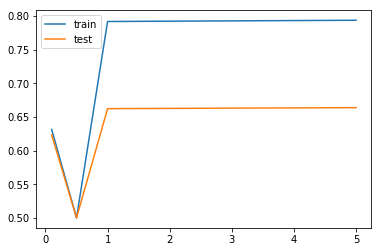

In [54]:
train_results=np.zeros(4)
test_results=np.zeros(4)
min_samples_leafs = [0.1, 0.5, 1, 5]
for i,s in enumerate(min_samples_leafs):
    clf = RandomForestClassifier(n_estimators=75, n_jobs=4, max_depth=12,
                                      min_samples_split=16, min_samples_leaf=s)
    clf.fit(X_train, y_train)
    randomforest_y_train_predict2=clf.predict_proba(X_train)[:,1]
    randomforest_y_test_predict2=clf.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_train, randomforest_y_train_predict2)
    train_results[i]=auc(fpr, tpr)
    fpr, tpr, thresholds = roc_curve(y_test, randomforest_y_test_predict2)
    test_results[i]=auc(fpr, tpr)
plt.plot(min_samples_leafs,train_results)
plt.plot(min_samples_leafs,test_results)
plt.legend(['train','test'])
plt.show()

When min_samples_leaf=1, it gets its best score

In [60]:
clf = RandomForestClassifier(n_estimators=75, n_jobs=4, max_depth=12,
                             min_samples_split=16, min_samples_leaf=1)
clf.fit(X_train, y_train)
randomforest_y_train_predict3=clf.predict_proba(X_train)[:,1]
randomforest_y_test_predict3=clf.predict_proba(X_test)[:,1]

print('Training result:')
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, randomforest_y_train_predict3)
print('AUC=',auc(fpr_train, tpr_train))
print('Accuracy=',accuracy_score(y_train, (randomforest_y_train_predict3 > threshold)))

print('Testing result:')
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, randomforest_y_test_predict3)
print('AUC=',auc(fpr_test, tpr_test))
print('Accuracy=',accuracy_score(y_test, (randomforest_y_test_predict3 > threshold)))

Training result:
('AUC=', 0.7979660512087333)
('Accuracy=', 0.8898770406220442)
Testing result:
('AUC=', 0.6623904472560297)
('Accuracy=', 0.8883702648258242)


It finally can get 0.6624 score on the test data.

## Gradient boosting

This time we use a gradient boosting classifier model.

In [62]:
from sklearn.ensemble import GradientBoostingClassifier

gboost = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,
                                    subsample=0.8, min_samples_split=2,
                                    min_samples_leaf=1, max_depth=3)
gboost.fit(X_train, y_train)

gboost_y_train_predict = gboost.predict_proba(X_train)[:,1]
gboost_y_test_predict = gboost.predict_proba(X_test)[:,1]

print('Training result:')
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, gboost_y_train_predict)
print('AUC=',auc(fpr_train, tpr_train))
print('Accuracy=',accuracy_score(y_train, (gboost_y_train_predict > threshold)))

print('Testing result:')
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, gboost_y_test_predict)
print('AUC=',auc(fpr_test, tpr_test))
print('Accuracy=',accuracy_score(y_test, (gboost_y_test_predict > threshold)))

Training result:
('AUC=', 0.6876886060493804)
('Accuracy=', 0.8895699492685084)
Testing result:
('AUC=', 0.6702407273001365)
('Accuracy=', 0.8889598584975188)


The gradient boosting method is used widely in industrial, it can get 0.67 score on the test data